In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [86]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [16]:
import csv
from ast import literal_eval

with open('simulations_w_logslope.csv','r') as csvfile:
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df)
#df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.bs = df.bs.apply(literal_eval)
#df.ms = df.ms.apply(literal_eval)
df.ms = ms_corrected
df.intact_fracs = df.intact_fracs.apply(literal_eval)
logLs = df.logLs
lams = df.lams


        ms   bs                                       intact_fracs  \
0     -0.1  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1     -0.1  0.1  [0.0034553558014923133, 0.002704191496820071, ...   
2     -0.1  0.2  [0.03670689568831689, 0.035304722319595375, 0....   
3     -0.1  0.3  [0.10611447744003205, 0.10941960038058991, 0.1...   
4     -0.1  0.4  [0.19425108918824177, 0.2002604036256197, 0.19...   
..     ...  ...                                                ...   
116  -10.0  0.6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
117  -10.0  0.7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
118  -10.0  0.8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
119  -10.0  0.9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
120  -10.0  1.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                 logLs  \
0    [-211.26147081059835, -253.53049025848497, -24...   
1    [-243.66948217350182, -226.08432471799

In [5]:
print(df.lams[40][0:2])
print(df.logLs[40][0:30])

[[19244.0, 628.0, 72.0, 15.0, 8.0, 2.0], [19146.0, 727.0, 68.0, 18.0, 7.0, 3.0]]
[-179.24104946035627, -245.251


In [6]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #print(lam)
    for i in range(len(lam)):
        term3 = -lgamma(k[i]+1)
        term2 = -lam[i]
        term1 = k[i]*np.log(lam[i])
        #print(term1, term2, term3)
        logL.append(term1+term2+term3)
    return np.sum(logL)

In [7]:
print(better_loglike(df.lams[40][0], k))

-179.24104946035627


In [8]:
test_k = [19653, 244, 51, 12, 8, 1]
test_lam = [1000, 718.884, 359.442, 207.67759999999998, 63.9008, 1e-10]
better_loglike(test_lam, test_k)

-40538.56317220582

In [9]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.26147081059835, -253.53049025848497, -24...","[[19270.0, 646.0, 53.0, 0.0, 0.0, 0.0], [19211...","[[18718.0, 1112.0, 139.0, 0.0, 0.0, 0.0], [186...","[-600.7598271276006, -678.2894487595215, -655...."
1,-0.1,0.1,"[0.0034553558014923133, 0.002704191496820071, ...","[-243.66948217350182, -226.08432471799637, -25...","[[19209.0, 703.0, 54.0, 2.0, 1.0, 0.0], [19256...","[[18634.0, 1186.0, 146.0, 2.0, 1.0, 0.0], [186...","[-662.6107761504626, -649.7932407307206, -703...."
2,-0.1,0.2,"[0.03670689568831689, 0.035304722319595375, 0....","[-207.1509747542354, -241.9780318513591, -235....","[[19228.0, 672.0, 53.0, 12.0, 2.0, 0.0], [1917...","[[18615.0, 1199.0, 128.0, 11.0, 9.0, 5.0], [18...","[-645.0662123050206, -662.9981181351045, -639...."
3,-0.1,0.3,"[0.10611447744003205, 0.10941960038058991, 0.1...","[-241.78238926525447, -222.0494810509071, -233...","[[19141.0, 702.0, 96.0, 11.0, 11.0, 7.0], [191...","[[18512.0, 1178.0, 189.0, 44.0, 28.0, 14.0], [...","[-709.80249091479, -675.2245274083217, -702.79..."
4,-0.1,0.4,"[0.19425108918824177, 0.2002604036256197, 0.19...","[-274.9891536504363, -279.3937875192433, -226....","[[19076.0, 703.0, 122.0, 42.0, 16.0, 7.0], [19...","[[18433.0, 1159.0, 223.0, 73.0, 43.0, 31.0], [...","[-776.0799497947147, -760.3296664040486, -686...."
...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.56722332975176, -235.39311682225818, -21...","[[19259.0, 662.0, 48.0, 0.0, 0.0, 0.0], [19234...","[[18663.0, 1177.0, 129.0, 0.0, 0.0, 0.0], [186...","[-648.5386217422094, -645.4542932462666, -640...."
117,-10.0,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-261.0856573186526, -259.6527909365831, -243....","[[19201.0, 721.0, 47.0, 0.0, 0.0, 0.0], [19209...","[[18645.0, 1206.0, 118.0, 0.0, 0.0, 0.0], [186...","[-666.1090896566407, -691.5098676575723, -658...."
118,-10.0,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-253.18341609675926, -200.3648525639819, -228...","[[19224.0, 707.0, 38.0, 0.0, 0.0, 0.0], [19291...","[[18598.0, 1236.0, 135.0, 0.0, 0.0, 0.0], [186...","[-702.853099626931, -621.302306949582, -664.59..."
119,-10.0,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.9969450415295, -232.03499150820488, -232...","[[19288.0, 644.0, 37.0, 0.0, 0.0, 0.0], [19241...","[[18714.0, 1124.0, 131.0, 0.0, 0.0, 0.0], [186...","[-605.3642031381569, -677.8752865389487, -654...."


In [13]:
logLs = df.logLs
lams = df.lams

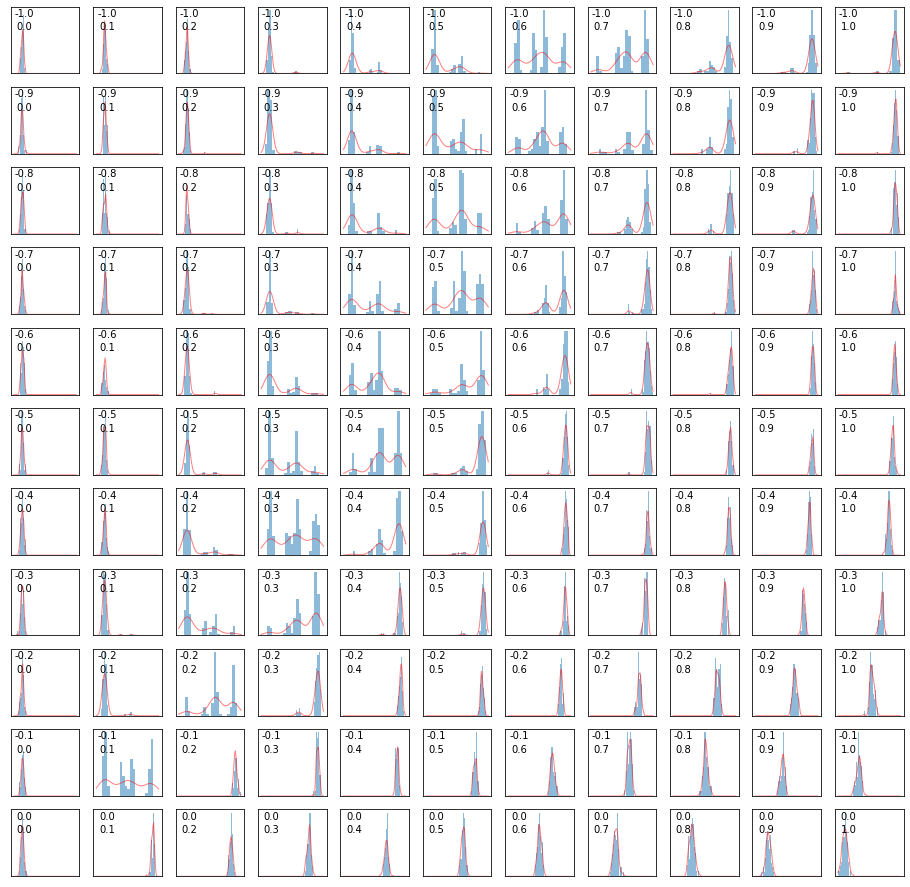

In [14]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
logLs = df.fixed_logLs
lams = df.fixed_lams
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

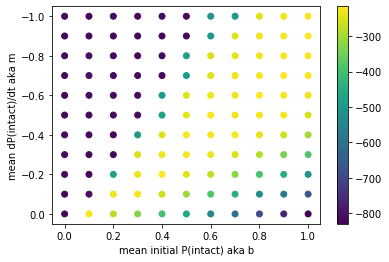

In [15]:
plt.scatter(bs, ms, c=mean_logLs)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [16]:
nonzero_k = k[1:]
print(nonzero_k)

1    244
2     51
3     12
4      8
5      1
dtype: int64


In [17]:
df

,ms,bs,intact_fracs,logLs,lams,fixed_lams,fixed_logLs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19256.0, 669.0, 44.0, 0.0, 0.0, 0.0], [19250...","[[19256.0, 669.0, 44.0, 1e-12, 1e-12, 1e-12], ...","[-806.7513443330784, -809.9130482406594, -785...."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19276.0, 639.0, 54.0, 0.0, 0.0, 0.0], [19238...","[[19276.0, 639.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[-787.0997072541483, -817.0971154538378, -811...."
2,-1.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19229.0, 702.0, 38.0, 0.0, 0.0, 0.0], [19230...","[[19229.0, 702.0, 38.0, 1e-12, 1e-12, 1e-12], ...","[-830.0556767758704, -818.3073011005523, -827...."
3,-1.0,0.3,"[0.0002003104812459312, 0.0001502328609344484,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19243.0, 678.0, 48.0, 0.0, 0.0, 0.0], [19232...","[[19243.0, 678.0, 48.0, 1e-12, 1e-12, 1e-12], ...","[-812.3256376092919, -489.1377593695547, -822...."
4,-1.0,0.4,"[5.00776203114828e-05, 0.00045069858280334516,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19251.0, 668.0, 50.0, 0.0, 0.0, 0.0], [19245...","[[19251.0, 668.0, 50.0, 1e-12, 1e-12, 1e-12], ...","[-805.7005861137114, -479.1030850084702, -835...."
...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.6022334618658921, 0.5987781060643999, 0.596...","[-524.667886730223, -535.3771760342797, -559.0...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[-524.667886730223, -535.3771760342797, -559.0..."
117,0.0,0.7,"[0.6972807852170865, 0.7000851319545295, 0.697...","[-623.8984971417495, -603.3751887016164, -578....","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[-623.8984971417495, -603.3751887016164, -578...."
118,0.0,0.8,"[0.7990385096900195, 0.8006910711602985, 0.801...","[-686.6116177184294, -716.7521832813926, -720....","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[-686.6116177184294, -716.7521832813926, -720...."
119,0.0,0.9,"[0.9013470879863789, 0.8981921979067554, 0.897...","[-768.1425145723931, -790.9071078681334, -792....","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[-768.1425145723931, -790.9071078681334, -792...."


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2357: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


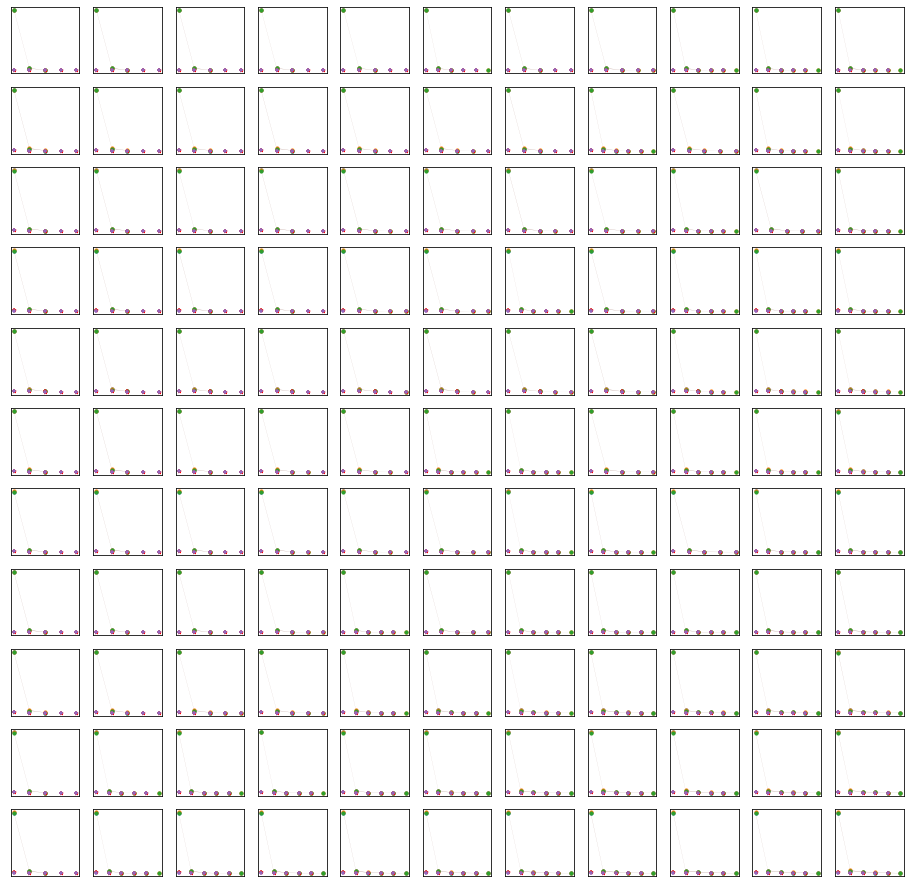

In [20]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
plt.figure(figsize=(16,16))
index = 0

short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=10)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=10)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=10)
        ax.scatter(np.arange(5), nonzero_k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(5), nonzero_k+np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), nonzero_k-np.sqrt(nonzero_k), marker='+', s=10)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

In [86]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,fixed_logLs,mean_intact_fracs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12...","[-650.6537307208537, -639.4163620330708, -679....",0.000000
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125...","[-598.5798560691655, -608.7858637087382, -642....",0.000000
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12...","[-640.1654150420494, -609.3868222906657, -607....",0.000010
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12...","[-600.4239216535047, -633.362728754572, -633.6...",0.000081
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120...","[-673.5307648193615, -598.8594688218777, -597....",0.000415
...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11...","[-1083.8886428193034, -1138.0793238613696, -11...",0.600252
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11...","[-1227.8254671542775, -1200.6712207379887, -11...",0.699880
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12...","[-1324.9824728296974, -1348.7435038027836, -12...",0.800016
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15...","[-1491.6045251895155, -1456.4168055744135, -15...",0.899931


In [46]:
df['mean_logLs'] = mean_logLs
df['mean_lams'] = lam_avgs

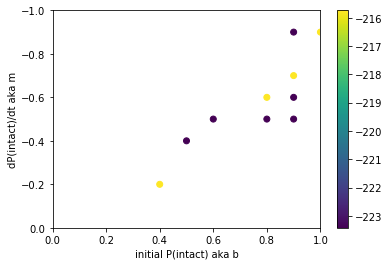

In [47]:
top_df = df.sort_values(['mean_logLs'], ascending=False).head(n=10)
plt.scatter(top_df.bs.to_list(), top_df.ms.to_list(), c=top_df.mean_logLs.to_list())
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m')
plt.xlim(0., 1.)
plt.ylim(-1., 0.)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [ ]:
# Model and transit multiplicity plots for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axes = axes.flatten()

for row in range(len(top_df.ms)):    
    logL = top_df.mean_logLs.to_list()[row]
    lam = pd.Series(top_df.mean_lams.to_list()[row])
    #lam.index += 1 # reset indices starting at 1 after reading back from list
    #print(lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.scatter(pd.Series(lam).index, lam)
    plt.scatter(np.arange(6), k, marker=(5, 1), color='r')
    #plt.scatter(np.arange(6), k+np.sqrt(k), marker='+')
    #plt.scatter(np.arange(6), k-np.sqrt(k), marker='+')
    print(lam)

#plt.title('Probability of staying intact as a function of time')
plt.show()

#### Troubleshooting: how to deal with zero-valued bins 

In [88]:
df.loc[(df.ms == 0) & (df.bs == 1)].lams

120    [[18311.0, 844.0, 442.0, 232.0, 106.0, 28.0], ...
Name: lams, dtype: object

In [89]:
df.loc[(df.ms == 0) & (df.bs == 0)].lams

110    [[19215.0, 712.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

In [87]:
df.loc[(df.ms == -1) & (df.bs == 0)].lams

0    [[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

In [90]:
df.loc[(df.ms == -1) & (df.bs == 1)].lams

10    [[19211.0, 688.0, 56.0, 8.0, 5.0, 1.0], [19234...
Name: lams, dtype: object

In [121]:
# multimodal population
df.loc[(df.ms == -1) & (df.bs == 0.6)].lams

6    [[19232.0, 695.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

### Redo but without zero bin

In [20]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf
    """

    logL = []
    #print(lam)
    for i in range(len(lam)):
        if lam[i]==0:    
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)
        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

In [19]:
### re-introduce nonzero-bin transit multiplicities
df_lams_nonzero = []
for x in df.lams:
    df_lams_nonzero.append([y[1:] for y in x])
df['lams_nonzero'] = df_lams_nonzero

In [21]:
fixed_logLs_nonzero = []
for x in df.lams_nonzero:
    temp_fixed_logLs_nonzero = []
    for y in x:
        #print(y, k[1:])
        temp_fixed_logLs_nonzero.append(better_loglike(y, k[1:].reset_index()[0]))
    fixed_logLs_nonzero.append(temp_fixed_logLs_nonzero)
df['logLs_nonzero'] = fixed_logLs_nonzero

In [22]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.26147081059835, -253.53049025848497, -24...","[[19270.0, 646.0, 53.0, 0.0, 0.0, 0.0], [19211...","[[18718.0, 1112.0, 139.0, 0.0, 0.0, 0.0], [186...","[-600.7598271276006, -678.2894487595215, -655....","[[646.0, 53.0, 0.0, 0.0, 0.0], [710.0, 48.0, 0...","[-201.61835461604724, -242.62241688522965, -23..."
1,-0.1,0.1,"[0.0034553558014923133, 0.002704191496820071, ...","[-243.66948217350182, -226.08432471799637, -25...","[[19209.0, 703.0, 54.0, 2.0, 1.0, 0.0], [19256...","[[18634.0, 1186.0, 146.0, 2.0, 1.0, 0.0], [186...","[-662.6107761504626, -649.7932407307206, -703....","[[703.0, 54.0, 2.0, 1.0, 0.0], [667.0, 45.0, 0...","[-232.71528698686052, -216.15776294846177, -24..."
2,-0.1,0.2,"[0.03670689568831689, 0.035304722319595375, 0....","[-207.1509747542354, -241.9780318513591, -235....","[[19228.0, 672.0, 53.0, 12.0, 2.0, 0.0], [1917...","[[18615.0, 1199.0, 128.0, 11.0, 9.0, 5.0], [18...","[-645.0662123050206, -662.9981181351045, -639....","[[672.0, 53.0, 12.0, 2.0, 0.0], [716.0, 66.0, ...","[-196.62634120941806, -230.28167747319878, -22..."
3,-0.1,0.3,"[0.10611447744003205, 0.10941960038058991, 0.1...","[-241.78238926525447, -222.0494810509071, -233...","[[19141.0, 702.0, 96.0, 11.0, 11.0, 7.0], [191...","[[18512.0, 1178.0, 189.0, 44.0, 28.0, 14.0], [...","[-709.80249091479, -675.2245274083217, -702.79...","[[702.0, 96.0, 11.0, 11.0, 7.0], [684.0, 82.0,...","[-229.13299717798, -210.10277438281167, -221.4..."
4,-0.1,0.4,"[0.19425108918824177, 0.2002604036256197, 0.19...","[-274.9891536504363, -279.3937875192433, -226....","[[19076.0, 703.0, 122.0, 42.0, 16.0, 7.0], [19...","[[18433.0, 1159.0, 223.0, 73.0, 43.0, 31.0], [...","[-776.0799497947147, -760.3296664040486, -686....","[[703.0, 122.0, 42.0, 16.0, 7.0], [697.0, 118....","[-260.4875109005878, -264.7707229235321, -214...."
...,...,...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.56722332975176, -235.39311682225818, -21...","[[19259.0, 662.0, 48.0, 0.0, 0.0, 0.0], [19234...","[[18663.0, 1177.0, 129.0, 0.0, 0.0, 0.0], [186...","[-648.5386217422094, -645.4542932462666, -640....","[[662.0, 48.0, 0.0, 0.0, 0.0], [683.0, 52.0, 0...","[-211.70227392522781, -225.00014574723465, -20..."
117,-10.0,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-261.0856573186526, -259.6527909365831, -243....","[[19201.0, 721.0, 47.0, 0.0, 0.0, 0.0], [19209...","[[18645.0, 1206.0, 118.0, 0.0, 0.0, 0.0], [186...","[-666.1090896566407, -691.5098676575723, -658....","[[721.0, 47.0, 0.0, 0.0, 0.0], [718.0, 42.0, 0...","[-249.94484394541962, -248.6985957499418, -233..."
118,-10.0,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-253.18341609675926, -200.3648525639819, -228...","[[19224.0, 707.0, 38.0, 0.0, 0.0, 0.0], [19291...","[[18598.0, 1236.0, 135.0, 0.0, 0.0, 0.0], [186...","[-702.853099626931, -621.302306949582, -664.59...","[[707.0, 38.0, 0.0, 0.0, 0.0], [629.0, 49.0, 0...","[-242.56994450535066, -191.12745929161065, -21..."
119,-10.0,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.9969450415295, -232.03499150820488, -232...","[[19288.0, 644.0, 37.0, 0.0, 0.0, 0.0], [19241...","[[18714.0, 1124.0, 131.0, 0.0, 0.0, 0.0], [186...","[-605.3642031381569, -677.8752865389487, -654....","[[644.0, 37.0, 0.0, 0.0, 0.0], [678.0, 50.0, 0...","[-202.70301841584234, -221.7932095958683, -222..."


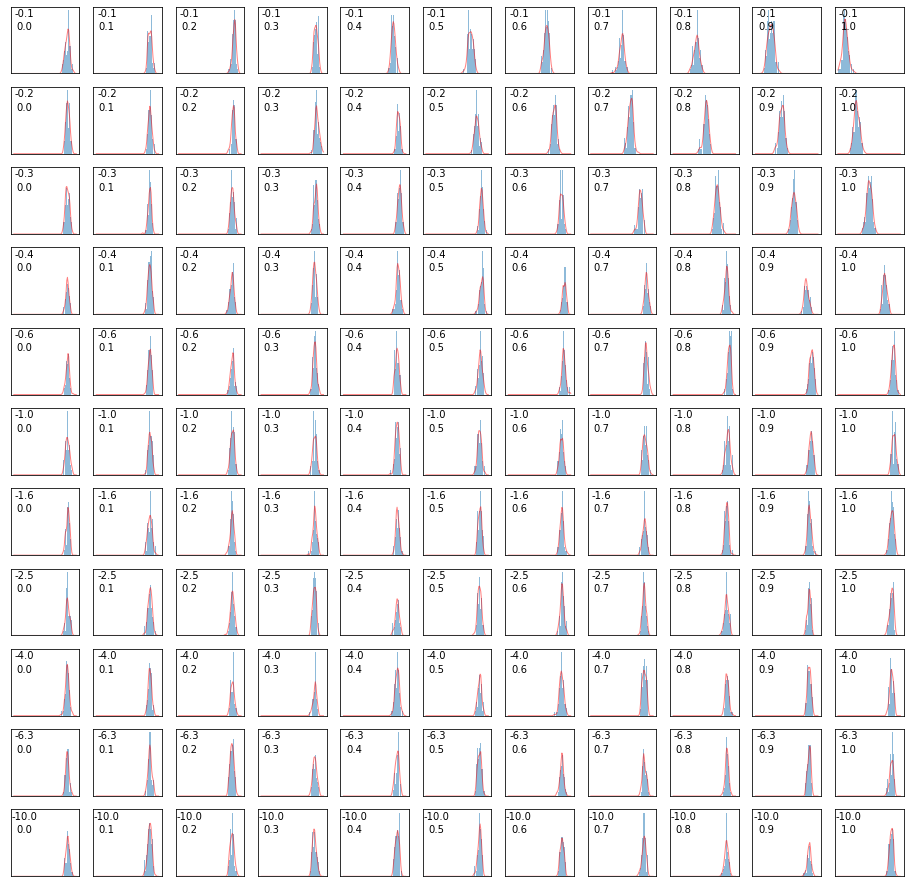

In [25]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
logLs = df.logLs_nonzero
lams = df.lams_nonzero
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

In [26]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.26147081059835, -253.53049025848497, -24...","[[19270.0, 646.0, 53.0, 0.0, 0.0, 0.0], [19211...","[[18718.0, 1112.0, 139.0, 0.0, 0.0, 0.0], [186...","[-600.7598271276006, -678.2894487595215, -655....","[[646.0, 53.0, 0.0, 0.0, 0.0], [710.0, 48.0, 0...","[-201.61835461604724, -242.62241688522965, -23..."
1,-0.1,0.1,"[0.0034553558014923133, 0.002704191496820071, ...","[-243.66948217350182, -226.08432471799637, -25...","[[19209.0, 703.0, 54.0, 2.0, 1.0, 0.0], [19256...","[[18634.0, 1186.0, 146.0, 2.0, 1.0, 0.0], [186...","[-662.6107761504626, -649.7932407307206, -703....","[[703.0, 54.0, 2.0, 1.0, 0.0], [667.0, 45.0, 0...","[-232.71528698686052, -216.15776294846177, -24..."
2,-0.1,0.2,"[0.03670689568831689, 0.035304722319595375, 0....","[-207.1509747542354, -241.9780318513591, -235....","[[19228.0, 672.0, 53.0, 12.0, 2.0, 0.0], [1917...","[[18615.0, 1199.0, 128.0, 11.0, 9.0, 5.0], [18...","[-645.0662123050206, -662.9981181351045, -639....","[[672.0, 53.0, 12.0, 2.0, 0.0], [716.0, 66.0, ...","[-196.62634120941806, -230.28167747319878, -22..."
3,-0.1,0.3,"[0.10611447744003205, 0.10941960038058991, 0.1...","[-241.78238926525447, -222.0494810509071, -233...","[[19141.0, 702.0, 96.0, 11.0, 11.0, 7.0], [191...","[[18512.0, 1178.0, 189.0, 44.0, 28.0, 14.0], [...","[-709.80249091479, -675.2245274083217, -702.79...","[[702.0, 96.0, 11.0, 11.0, 7.0], [684.0, 82.0,...","[-229.13299717798, -210.10277438281167, -221.4..."
4,-0.1,0.4,"[0.19425108918824177, 0.2002604036256197, 0.19...","[-274.9891536504363, -279.3937875192433, -226....","[[19076.0, 703.0, 122.0, 42.0, 16.0, 7.0], [19...","[[18433.0, 1159.0, 223.0, 73.0, 43.0, 31.0], [...","[-776.0799497947147, -760.3296664040486, -686....","[[703.0, 122.0, 42.0, 16.0, 7.0], [697.0, 118....","[-260.4875109005878, -264.7707229235321, -214...."
...,...,...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-221.56722332975176, -235.39311682225818, -21...","[[19259.0, 662.0, 48.0, 0.0, 0.0, 0.0], [19234...","[[18663.0, 1177.0, 129.0, 0.0, 0.0, 0.0], [186...","[-648.5386217422094, -645.4542932462666, -640....","[[662.0, 48.0, 0.0, 0.0, 0.0], [683.0, 52.0, 0...","[-211.70227392522781, -225.00014574723465, -20..."
117,-10.0,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-261.0856573186526, -259.6527909365831, -243....","[[19201.0, 721.0, 47.0, 0.0, 0.0, 0.0], [19209...","[[18645.0, 1206.0, 118.0, 0.0, 0.0, 0.0], [186...","[-666.1090896566407, -691.5098676575723, -658....","[[721.0, 47.0, 0.0, 0.0, 0.0], [718.0, 42.0, 0...","[-249.94484394541962, -248.6985957499418, -233..."
118,-10.0,0.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-253.18341609675926, -200.3648525639819, -228...","[[19224.0, 707.0, 38.0, 0.0, 0.0, 0.0], [19291...","[[18598.0, 1236.0, 135.0, 0.0, 0.0, 0.0], [186...","[-702.853099626931, -621.302306949582, -664.59...","[[707.0, 38.0, 0.0, 0.0, 0.0], [629.0, 49.0, 0...","[-242.56994450535066, -191.12745929161065, -21..."
119,-10.0,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-211.9969450415295, -232.03499150820488, -232...","[[19288.0, 644.0, 37.0, 0.0, 0.0, 0.0], [19241...","[[18714.0, 1124.0, 131.0, 0.0, 0.0, 0.0], [186...","[-605.3642031381569, -677.8752865389487, -654....","[[644.0, 37.0, 0.0, 0.0, 0.0], [678.0, 50.0, 0...","[-202.70301841584234, -221.7932095958683, -222..."


In [33]:
10**ms

0      7.943282e-01
1      7.943282e-01
2      7.943282e-01
3      7.943282e-01
4      7.943282e-01
           ...     
116    1.000000e-10
117    1.000000e-10
118    1.000000e-10
119    1.000000e-10
120    1.000000e-10
Name: ms, Length: 121, dtype: float64

In [79]:
np.log10(np.logspace(8,10,11))

array([ 8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [72]:
10**(ms*1e9)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
Name: ms, Length: 121, dtype: float64

In [73]:
-1e-9*np.logspace(8,10,11)

array([ -0.1       ,  -0.15848932,  -0.25118864,  -0.39810717,
        -0.63095734,  -1.        ,  -1.58489319,  -2.51188643,
        -3.98107171,  -6.30957344, -10.        ])

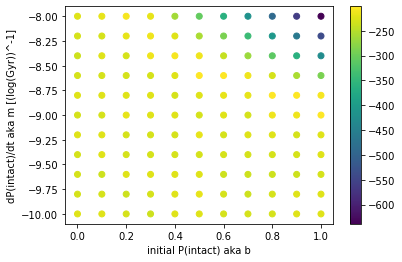

In [121]:
plt.scatter(bs, [-1*m for m in ms_corrected_for_plotting], c=mean_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
#plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
#plt.yscale('log')
plt.colorbar()
plt.show()

Alternative way of displaying

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


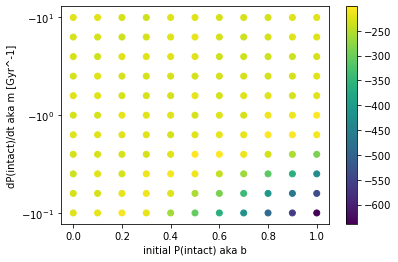

In [122]:
plt.scatter(bs, df.ms, c=mean_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [Gyr^-1]')
#plt.gca().invert_yaxis()
plt.yscale('symlog', linthreshy=0.1)
#plt.yscale('symlog', base=10)
#plt.yscale('log')
plt.colorbar()
#plt.tight_layout()
plt.ylim(-0.09, -13) 
plt.show()

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if __name__ == '__main__':


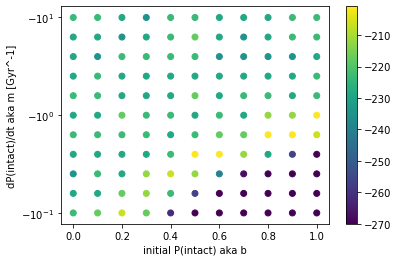

In [123]:
# to better show color differences for logL comparison
mean_logLs_new = np.array(mean_logLs)
mean_logLs_new[mean_logLs_new < -270] = -270

plt.scatter(bs, df.ms, c=mean_logLs_new) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [Gyr^-1]')
#plt.gca().invert_yaxis()
plt.yscale('symlog', linthreshy=0.1)
#plt.yscale('symlog', base=10)
#plt.yscale('log')
plt.colorbar()
#plt.tight_layout()
plt.ylim(-0.09, -13) 
plt.show()

In [117]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))

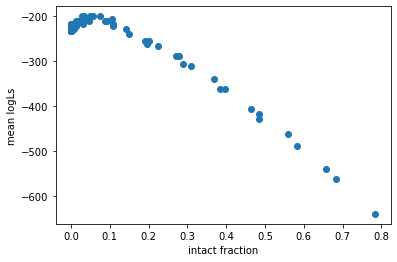

In [118]:
plt.scatter(df.mean_intact_fracs, mean_logLs)
plt.ylabel('mean logLs')
plt.xlabel('intact fraction')
plt.show()

/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/ma/core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/ma/core.py:2363: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


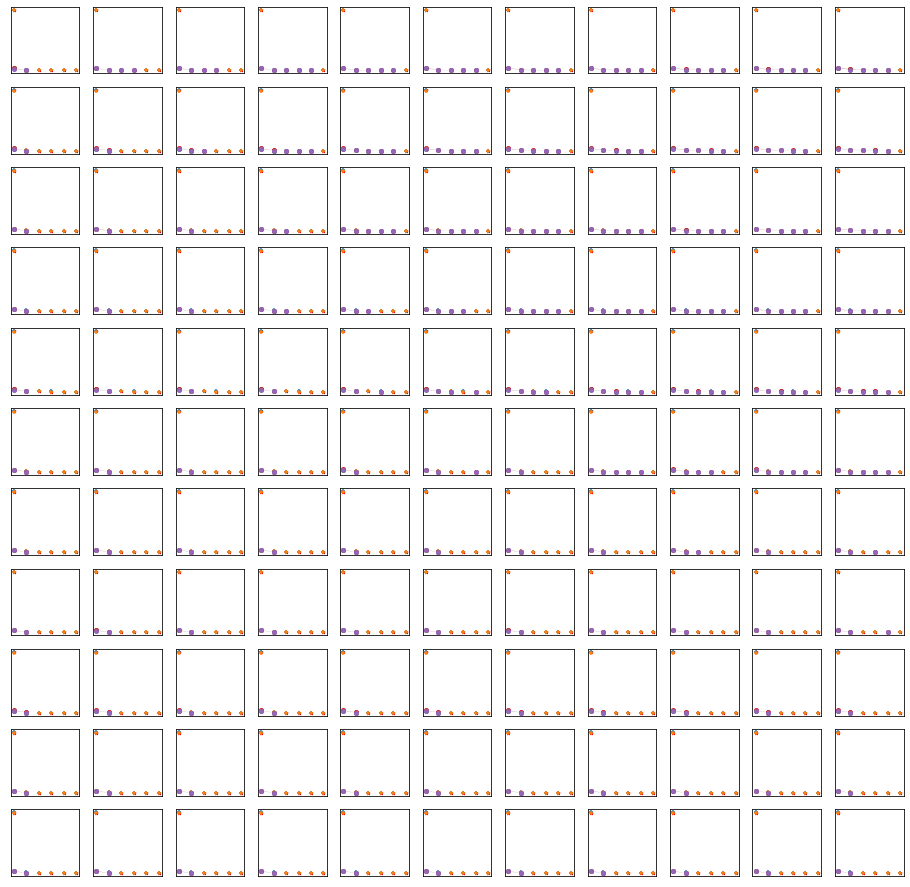

In [119]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

plt.figure(figsize=(16,16))
index = 0

#short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(np.arange(6), k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(6), k+np.sqrt(k), marker='+', s=10)
        ax.scatter(np.arange(6), k-np.sqrt(k), marker='+', s=10)
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=16)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=16)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=16)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

IndexError: invalid index to scalar variable.

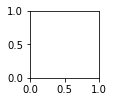

In [137]:
plt.figure(figsize=(16,16))
index = 0
x = np.linspace(0, 10, 100)

def prob_intact(x, m, b, cutoff):
    prob = m*x + b
    prob = [0.05 if i < 0.05 else i for i in prob]
    return prob

for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        #cube = [random.uniform(0,1), random.uniform(0,1)]
        #cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        cutoff = 0 # placeholder
        round(ms[index], 1)
        
        y = prob_intact(x, round(cube[0], 1), round(cube[1], 1, cutoff))
        #y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
        ax.plot(x, y)
        ax.set_ylim([0, 1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

### Inspect individual transit files (batches of 19600)

In [133]:
a = pd.read_csv('sample_transit_data_logslope/transits0_0_1.csv')
b = pd.read_csv('sample_transit_data_logslope/transits5_0_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
#a['num_planets'] = a.planet_inclinations.str.len()
#b['num_planets'] = b.planet_inclinations.str.len()
a['num_planets'] = [len(row) for row in a.planet_inclinations]
b['num_planets'] = [len(row) for row in b.planet_inclinations]
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

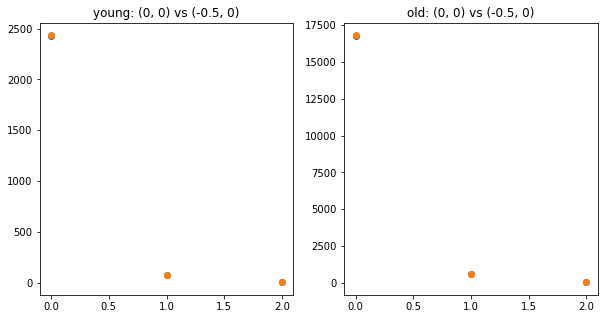

0    2432
1      74
2       8
Name: transit_multiplicity, dtype: int64
0    2434
1      77
2       3
Name: transit_multiplicity, dtype: int64
0    16779
1      636
2       40
Name: transit_multiplicity, dtype: int64
0    16794
1      610
2       51
Name: transit_multiplicity, dtype: int64


In [134]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(a_young.transit_multiplicity.value_counts().index, a_young.transit_multiplicity.value_counts())
ax.scatter(b_young.transit_multiplicity.value_counts().index, b_young.transit_multiplicity.value_counts())
ax.set_title('young: (0, 0) vs (-0.5, 0)')

ax = axes[1]
ax.scatter(a_old.transit_multiplicity.value_counts().index, a_old.transit_multiplicity.value_counts())
ax.scatter(b_old.transit_multiplicity.value_counts().index, b_old.transit_multiplicity.value_counts())
ax.set_title('old: (0, 0) vs (-0.5, 0)')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [135]:
a.loc[a.star_ages < 0.5] # these are the stars with non-zero P(intact) in the (-1, 0.5) case; ~1% of FGK stars

,Unnamed: 0,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,impact_parameters,transit_status,...,geometric_transit_multiplicity,transit_multiplicity,kepid,y_intercept,slope,transit_duration,6hr_cdpp,signal_noise,prob_detections,num_planets
68,68,0.27,[24.056313462842],[0.17490502930107377],0.942064,[53.976278940176684],[1.021091460356562],[58.50423117528081],[26.949075371003726],[0],...,0,0,1571732,0.0,-0.1,[nan],134.900,[nan],[0.],1
93,93,0.26,"[9.283717718615172, 8.385534195037323]","[0.09100168449528516, 0.08503322222657744]",-0.725519,[-41.56917276426464],"[-0.7467739491744805, -0.9724513660469886]","[-42.78699553801478, -55.71735905622397]","[-11.99660163377752, -13.635573981206552]","[0, 0]",...,0,0,1718753,0.0,-0.1,[nan nan],44.813,[nan nan],[0. 0.],2
111,111,0.46,[3.8762205704039423],[0.05237215055227085],0.251237,[14.394831329657192],[0.14348016637906463],[8.220807977355255],[1.2780083748714284],[0],...,0,0,1722816,0.0,-0.1,[nan],85.155,[nan],[0.],1
217,217,0.35,[19.919736102057566],[0.15895908892577135],-0.780076,[-44.695063886119975],[-0.9241391195827899],[-52.949271235029556],[-20.745375553918738],[0],...,0,0,2019761,0.0,-0.1,[nan],163.566,[nan],[0.],1
430,430,0.48,"[4.520526162354457, 17.4392675330878]","[0.06000390629679302, 0.1475952427322614]",-0.505886,[-28.985140819512466],"[-0.5354310260912153, -0.7199684436184478]","[-30.6779380153857, -41.25115320193962]","[-4.705604194686802, -14.958255964674002]","[0, 0]",...,0,0,2452289,0.0,-0.1,[nan nan],55.937,[nan nan],[0. 0.],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19433,19433,0.30,[248.59286615193187],[0.8349274286118096],-1.159720,[-66.447089460137],[-1.1099083085667],[-63.59306172737579],[-132.67569424482198],[0],...,0,0,12024098,0.0,-0.1,[nan],35.270,[nan],[0.],1
19517,19517,0.29,"[15.268834424000126, 197.4541085243137]","[0.13066083153034858, 0.7198670198423942]",0.938251,[53.75782080737317],"[1.0648025903364235, 1.1244340645462767]","[61.00869444087465, 64.42532623924245]","[19.94773485129737, 113.33459129265023]","[0, 0]",...,0,0,12107925,0.0,-0.1,[nan nan],31.147,[nan nan],[0. 0.],2
19658,19658,0.47,"[275.6384419947161, 24.856157366927228]","[0.844765895833248, 0.1698761884821375]",0.827832,[47.43129387681254],"[0.8489224585380318, 0.8894263118017156]","[48.63967400809884, 50.96037385412511]","[136.34210037359796, 28.372316596866057]","[0, 0]",...,0,0,12215836,0.0,-0.1,[nan nan],57.862,[nan nan],[0. 0.],2
19672,19672,0.25,"[24.226570802111667, 182.12250236939394]","[0.17487068724274407, 0.6710653153566795]",-0.585802,[-33.56396784604226],"[-0.5428731634028716, -0.23185615756417982]","[-31.104341073900446, -13.28437928254772]","[-16.631451733202006, -28.388706207237707]","[0, 0]",...,0,0,12251653,0.0,-0.1,[nan nan],54.232,[nan nan],[0. 0.],2


In [136]:
print(a.y_intercept[0], a.slope[0])
print(b.y_intercept[0], b.slope[0])

0.0 -0.1
0.0 -1.0
